# Introduction to Convolutional Neural Networks, part 1

We will start looking at image classification, the task of training a model to classify an image into one of a pre-set number of categories. The image below shows common computer vision tasks and is from [Shivani Kolungade](https://medium.com/@kolungade.s/object-detection-image-classification-and-semantic-segmentation-using-aws-sagemaker-e1f768c8f57d)

![Image classification, object detection and segmentation by Shivani Kolungade](images/classification_detection_segmentation.png)


## Image classification of an American Sign Language Dataset

For this exercise, we will explore image classification, starting with a "simple" neural network and then adding convolutional layers, data augmentation and more to build better models.

This notebook is inspired by the Nvidia [Fundamentals of Deep Learning](https://www.nvidia.com/en-us/training/instructor-led-workshops/fundamentals-of-deep-learning/) (instructor led)/ [Getting Started with Deep Learning](https://courses.nvidia.com/courses/course-v1:DLI+S-FX-01+V1/about) (online, asynchronous) exercises. 

## American Sign Language Dataset

The American Sign Language [manual alphabet](https://en.wikipedia.org/wiki/American_manual_alphabet) has signs for each letter. We will skip J and Z because those signs require motion. 

The dataset we'll use is from [Kaggle](https://www.kaggle.com/arjaiswal/sign-mnist-using-cnn/data). There should be 24 classes...but for some reason, there are 25...It turns out they skipped class 9, the J class.

We'll start with this dataset because it helps with the transition from the tabular data we've been working with to image data. Images are a grid of pixels, where each pixel has a brightness. For greyscale images, there is one grid, for color images, there are typically three grids, for the red, green and blue colors (RGB), often called color channels.

Let's start by loading the data and examining some images.

## Load the data and examine some images

In [2]:
import numpy as np
import pandas as pd

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image as image_utils

from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense

from helpers_plot_history import plot_history # A function to plot training history. 
                            # We 1st used the code in 15_neural_networks.ipynb. 

In [3]:
sign_train = pd.read_csv("data/sign_mnist/sign_mnist_train.csv")
sign_test = pd.read_csv("data/sign_mnist/sign_mnist_test.csv")

In [4]:
sign_train.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


In [5]:
y_train = sign_train['label']
X_train = sign_train.drop(columns='label').values

y_test = sign_test['label']
X_test = sign_test.drop(columns='label').values

X_test.shape

(7172, 784)

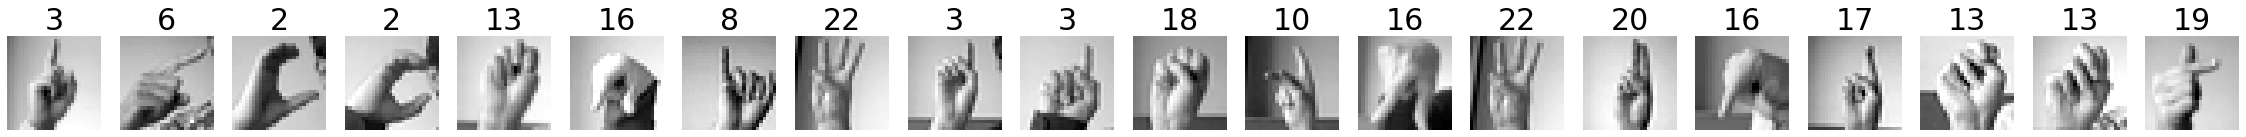

In [6]:
plt.figure(figsize=(40,40))

num_images = 20
for i in range(num_images):
    row = X_train[i]
    label = y_train[i]
    
    image = row.reshape(28,28)  # Note that we reshape the row into a 28X28 pixel image
    plt.subplot(1, num_images, i+1)
    plt.title(label, fontdict={'fontsize': 30})
    plt.axis('off')
    plt.imshow(image, cmap='gray')

In [ ]:
# Just to show that there are no samples in class 9
sign_train.groupby('label').size()

## Normalize the data

As we mentioned in previous classes, networks train better with standardized or normalized data. Normalization tends to work best with images, so can look at the min and max of our dataset to get those and divide by the max value

In [7]:
print(X_train.min(), X_train.max())

0 255


In [8]:
# Normalize our data (get values between 0-1)

X_train = X_train/255
X_test = X_test/255

## Labels to categorical

We want out labels to be categorical. As they are now, the labels are 0, 1,...,24 (to be honest, I am not sure why there are 25 classes. Should only be 24...). That would imply label 1 is more similar to label 2 than to label 23 and that label 3 is less than label 4. Converting to categorical labels converts these to named categories, removing the order/associations among the names.  

In [9]:
# Convert our classes to categorical

num_classes = 25 # Not entirely sure what the 25th category is...

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

## Make our model

I've kept the code format here as it was in the Nvidia exercise. This is another common method of making a model. So far, I've used the format below to keep things similar to `sklearn Pipelines`, but I want to expose you to this `model.add` format too. The code in the block below is the same as this:

    model = Sequential([
        layers.Dense(units = 512, activation='relu', input_shape=(784,))),
        layers.Dense(units = 512, activation='relu')),
        layers.Dense(units = num_classes, activation='softmax'))
        ])

In [10]:
model = Sequential()
model.add(Dense(units = 512, activation='relu', input_shape=(784,)))
model.add(Dense(units = 512, activation='relu'))
model.add(Dense(units = num_classes, activation='softmax'))

2022-03-01 15:19:23.295292: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-03-01 15:19:23.780042: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79125 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:bd:00.0, compute capability: 8.0


In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               401920    
_________________________________________________________________
dense_1 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_2 (Dense)              (None, 25)                12825     
Total params: 677,401
Trainable params: 677,401
Non-trainable params: 0
_________________________________________________________________


## Compile and fit our model

In [12]:
model.compile(loss='categorical_crossentropy', metrics=['accuracy'])

In [13]:
history = model.fit(X_train, y_train, epochs=20, verbose=1, validation_data=(X_test, y_test))

2022-03-01 15:19:25.339673: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/20
 65/858 [=>............................] - ETA: 1s - loss: 3.1917 - accuracy: 0.0803

2022-03-01 15:19:26.566877: I tensorflow/stream_executor/cuda/cuda_blas.cc:1760] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


858/858 [==============================] - 3s 2ms/step - loss: 1.9244 - accuracy: 0.3883 - val_loss: 1.6048 - val_accuracy: 0.4670
Epoch 2/20
858/858 [==============================] - 2s 2ms/step - loss: 0.9624 - accuracy: 0.6758 - val_loss: 0.9109 - val_accuracy: 0.6864
Epoch 3/20
858/858 [==============================] - 2s 2ms/step - loss: 0.5857 - accuracy: 0.8045 - val_loss: 0.8255 - val_accuracy: 0.7358
Epoch 4/20
858/858 [==============================] - 2s 2ms/step - loss: 0.3967 - accuracy: 0.8731 - val_loss: 1.0551 - val_accuracy: 0.7316
Epoch 5/20
858/858 [==============================] - 2s 2ms/step - loss: 0.2942 - accuracy: 0.9098 - val_loss: 0.7375 - val_accuracy: 0.8055
Epoch 6/20
858/858 [==============================] - 3s 3ms/step - loss: 0.2515 - accuracy: 0.9328 - val_loss: 1.2855 - val_accuracy: 0.7479
Epoch 7/20
858/858 [==============================] - 2s 2ms/step - loss: 0.2183 - accuracy: 0.9453 - val_loss: 0.7729 - val_accuracy: 0.8469
Epoch 8/20
858/85

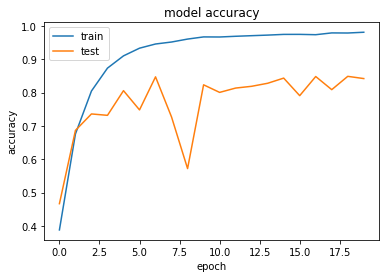

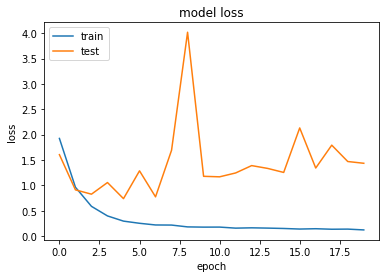

In [14]:
# Call the plot_history function we made and imported from helpers_plot_history.py

plot_history(history)

## How can we improve our model?

Honestly, that's not too bad with the data we have. About 80% accuracy for greyscale images 28X28 pixels seems remarkable to me! But, notice that the test accuracy is well below the training accuracy and test loss is going up or staying the same. We are overfitting our data.

We can do a number of things to improve on these results! Let's take a look.

Let's look at some slides that cover convolutional kernels, pooling, dropout and data augmentation for image classification in neural networks: [Lect_06_CNNs slides](https://docs.google.com/presentation/d/1uSk7xHWZ9H6YihUP4OdHpIVws_2py_HBfbby7GpZDCA/edit?usp=sharing)

Then, we can move to [part 2](17_CNNs_part2.ipynb) of this section.